# 고혈압 분석 모델

고혈압 판단 조건
1. 'AS1_BPLIE2S_A' 누운 자세 - 2회 sys 측정 평균 140 이상
2. 'AS1_BPLIE2D_A',누운 자세 - 2회 dia 측정 평균 90 이상
3. 'AS1_DrugHtCu' 2번 응답

## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - y: 종속변수
    - 'AS1_BPLIE2S_A'
    - 'AS1_BPLIE2D_A'
    - 'AS1_DrugHtCu'
    - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

- 17차
  - 2022-05-04
  - _1000 변수만으로 모델 학습

- 18차
  - 2022-05-13
  - 혈압을 예측하는 회귀모델 구현
  - _1000 변수 + 원래 쓰던거
  - 77777 to 0
    - AS1_DRDUA: 77777 to 0
    - AS1_HVSMAM: 77777 to 0

  - 그냥 삭제

- 19차
  - 2022-06-01
  - 데이터 describe
    - AS1_B01 있, 1000kcal 나눔
    - AS1_B01 있, 안 나눔
    - AS1_B01 없, 1000kcal 나눔
    - AS1_B01 없, 안 나눔
  
  - 유전적 요인 분석하기
    - 아빠: Father
    - 엄마: Mather
    - 형제자매: Sibling


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리

### 데이터 불러오기

In [2]:
# dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/dataset220705.xlsx',
#                         index_col=0, na_values=[77777, 99999, '#NULL!','#DIV/0!', 'NA', ' ']).astype('float64')
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/dataset220709.csv',
                      index_col=0, na_values=[77777, 99999, '#NULL!','#DIV/0!', 'NA', ' ']).astype('float64')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9705 entries, EPI20_026_2_000001 to nan
Columns: 104 entries, AS1_SEX to AS1_BPLIE2D_A
dtypes: float64(104)
memory usage: 7.8+ MB


### 결측값 제거

AS1_TOTALC

- 평균값으로 대치해야할 듯
- 근데 평균값이 거의 0임..?
- 최빈값인 0으로 대치

---


가족력 데이터 살려야 한다.

- 결측값 -> 0
- one hot vectorize + prefix
  0. _N
  1. _F
  2. _M
  3. _S
  4. _O

- AS1_FMHTREL1A
- AS1_FMDMREL1A
- AS1_FMHEREL1A
- AS1_FMCVAREL1A
- AS1_FMCDREL1A
- AS1_FMCHREL1A
- AS1_FMPVREL1A
- AS1_FMLPREL1A

In [4]:
# 결측값이 있는 종속변수는 제거
dataset.dropna(subset=['AS1_BPLIE2S_A', 'AS1_BPLIE2D_A'], inplace=True)
dataset['HYPERTENSION'] = np.where((dataset['AS1_DRUGHTCU_FILLNA'] == 2) | (dataset['AS1_BPLIE2S_A'] >= 140) | (dataset['AS1_BPLIE2D_A'] >= 90), 1, 0)

In [5]:
# 키, 몸무게 그룹별 평균으로 대치
condition = [(dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 60),  # 60대 남자
             (dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 50),  # 50대 남자
             (dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 40),  # 40대 남자
             (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 60),  # 60대 여자
             (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 50),  # 50대 여자
             (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 40)   # 40대 여자
            ]
choice = ['M60', 'M50', 'M40', 'F60', 'F50', 'F40']

dataset['group'] = np.select(condition, choice, default=np.nan)

fill_mean_func = lambda g: g.fillna(g.mean()) # 각 그룹별 평균으로 결측값 대치

dataset['AS1_HEIGHT'] = dataset.groupby('group')['AS1_HEIGHT'].apply(fill_mean_func)
dataset['AS1_WEIGHT'] = dataset.groupby('group')['AS1_WEIGHT'].apply(fill_mean_func)

In [6]:
# BMI 계산
dataset['AS1_BMI'] = np.where(pd.notnull(dataset['AS1_BMI']) == True, # null이 아니면?
                              dataset['AS1_BMI'],  # 원래 값 그대로 
                              dataset['AS1_WEIGHT'] / ((dataset['AS1_HEIGHT']/100) ** 2)) # 아니면 bmi 계산

In [7]:
dataset['AS1_TOTALC'].fillna(0, inplace=True) # 음주 평균 (= 0, 최빈값)으로 대치

In [8]:
dataset.dropna(inplace=True)  # 나머지 결측값은 제거

### dataset 스케일링

#### dataset 분류

In [9]:
# dataset에 있는 변수 분리
# 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# 종속변수
label = dataset.reindex(columns=['AS1_DRUGHTCU_FILLNA',
                                 'AS1_BPLIE2S_A',
                                 'AS1_BPLIE2D_A',
                                 'HYPERTENSION'])

# 범주형(binary, 0 or 1)
raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS1_STRPHYSJ',
                                      'AS1_TIED', 'AS1_SLPAMSF'])
col_b = raw_binary.columns

# 범주형(계층 없음, without hierarchy)
raw_categoryH0 = dataset.reindex(columns=['AS1_DRINK', 'AS1_SMOKEA'])
col_H0 = raw_categoryH0.columns

# 범주형(계층 없음, without hierarchy), 20220601 가족력 추가
raw_FM = dataset.reindex(columns=['AS1_FMHTREL1A', 'AS1_FMDMREL1A',
                                  'AS1_FMHEREL1A', 'AS1_FMCVAREL1A',
                                  'AS1_FMCVBREL1A', # 누락됐었음.
                                  'AS1_FMCDREL1A', 'AS1_FMCHREL1A',
                                  'AS1_FMPVREL1A', 'AS1_FMLPREL1A'
                                  ])
col_FM = raw_FM.columns

# 범주형(계층 있음, with hierarchy)
raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRDUA',
                                          'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                          'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                          ])
col_H1 = raw_categoryH1.columns

# 연속형 변수
raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_TOTALC',
                                   'AS1_SLPAMTM', 'AS1_RGMEALFQA', 'AS1_HEIGHT',
                                   'AS1_WEIGHT', 'AS1_BMI', 'AS1_WAIST3_A',
                                   'DP1', 'DP2', 'DP3', 'DP4', 'DP5',
                                   'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
                                   'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17'  # 식사량 데이터 추가
                                   ])
col_c = raw_ctn.columns

In [ ]:
# # 영양소(nutrients) 변수 AS1_B01(에너지) 있, 1000kcal 나눔 (보정)
# raw_ntr_E1C1 = dataset.reindex(columns=['AS1_B01',
#                                    'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                                    'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                                    'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                                    'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                                    'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                                    'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                                    'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                                    'AS1_B24_1000',
#                                    ])

# # AS1_B01 있, 안 나눔
# raw_ntr_E1C0 = dataset.reindex(columns=['AS1_B01',
#                                    'AS1_B02', 'AS1_B03', 'AS1_B04',
#                                    'AS1_B05', 'AS1_B06', 'AS1_B07',
#                                    'AS1_B08', 'AS1_B09', 'AS1_B10',
#                                    'AS1_B11', 'AS1_B12', 'AS1_B13',
#                                    'AS1_B14', 'AS1_B15', 'AS1_B16',
#                                    'AS1_B17', 'AS1_B18', 'AS1_B19',
#                                    'AS1_B20', 'AS1_B21', 'AS1_B23',
#                                    'AS1_B24',
#                                    ])

# # AS1_B01 없, 1000kcal 나눔
# raw_ntr_E0C1 = dataset.reindex(columns=['AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                                    'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                                    'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                                    'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                                    'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                                    'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                                    'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                                    'AS1_B24_1000',
#                                    ])

# # AS1_B01 없, 안 나눔
# raw_ntr_E0C0 = dataset.reindex(columns=['AS1_B02', 'AS1_B03', 'AS1_B04',
#                                    'AS1_B05', 'AS1_B06', 'AS1_B07',
#                                    'AS1_B08', 'AS1_B09', 'AS1_B10',
#                                    'AS1_B11', 'AS1_B12', 'AS1_B13',
#                                    'AS1_B14', 'AS1_B15', 'AS1_B16',
#                                    'AS1_B17', 'AS1_B18', 'AS1_B19',
#                                    'AS1_B20', 'AS1_B21', 'AS1_B23',
#                                    'AS1_B24',
#                                    ])

In [10]:
raw_ntr = dataset.reindex(columns=['AS1_B01',
                                   'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
                                   'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
                                   'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
                                   'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
                                   'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
                                   'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
                                   'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
                                   'AS1_B24_1000',
                                   'AS1_B02', 'AS1_B03', 'AS1_B04',
                                   'AS1_B05', 'AS1_B06', 'AS1_B07',
                                   'AS1_B08', 'AS1_B09', 'AS1_B10',
                                   'AS1_B11', 'AS1_B12', 'AS1_B13',
                                   'AS1_B14', 'AS1_B15', 'AS1_B16',
                                   'AS1_B17', 'AS1_B18', 'AS1_B19',
                                   'AS1_B20', 'AS1_B21', 'AS1_B23',
                                   'AS1_B24',
                                   ])

In [11]:
# raw_ntr = raw_ntr_E1C1
col_n = raw_ntr.columns

#### 데이터 정보 내보내기

In [ ]:
# # Write two DataFrames to Excel using to_excel(). Need to specify an ExcelWriter object first.
# # 출처: https://rfriend.tistory.com/466 [R, Python 분석과 프로그래밍의 친구 (by R Friend):티스토리]
# with pd.ExcelWriter('./dsc.xlsx') as writer:
#   raw_ntr_E1C1.describe().to_excel(writer, sheet_name = 'E1C1')
#   raw_ntr_E1C0.describe().to_excel(writer, sheet_name = 'E1C0')
#   raw_ntr_E0C1.describe().to_excel(writer, sheet_name = 'E0C1')
#   raw_ntr_E0C0.describe().to_excel(writer, sheet_name = 'E0C0')


#### dataset 스케일링

SPSS에서 사용하기 위하여 이 과정 생략한 자료 만들 것.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

def quantile(categoryH1, ctn):
  categoryH1[col_H1] = QuantileTransformer().fit_transform(categoryH1)
  ctn[col_c] = QuantileTransformer().fit_transform(ctn)
  
  return categoryH1, ctn

In [ ]:
from sklearn.preprocessing import QuantileTransformer

categoryH1 = pd.DataFrame(QuantileTransformer().fit_transform(raw_categoryH1), index=dataset.index, columns=col_H1).astype('float')
ctn = pd.DataFrame(QuantileTransformer().fit_transform(raw_ctn), index=dataset.index, columns=col_c).astype('float')
nutrients = pd.DataFrame(QuantileTransformer().fit_transform(raw_ntr), index=dataset.index, columns=col_n).astype('float')

### 데이터셋 원핫인코딩

In [ ]:
categoryH0 = pd.get_dummies(raw_categoryH0, columns=col_H0, drop_first=True, dtype='float64') # one-hot-encoding
FM = pd.get_dummies(raw_FM, columns=col_FM, drop_first=True, dtype='float64') # one-hot-encoding

## dataset 분리
- train, test

In [12]:
X = pd.concat([raw_binary, raw_categoryH0, raw_categoryH1, raw_ctn, raw_ntr, raw_FM], axis=1)
# X = pd.concat([raw_binary, categoryH0, categoryH1, ctn, nutrients, FM], axis=1)
raw_y = label
# raw_y = pd.DataFrame(QuantileTransformer().fit_transform(label), index=dataset.index, columns=label.columns)

In [13]:
X

,AS1_SEX,AS1_STRPHYSJ,AS1_TIED,AS1_SLPAMSF,AS1_DRINK,AS1_SMOKEA,AS1_EDUA,AS1_INCOME,AS1_DRDUA,AS1_PHYSTB,...,AS1_B24,AS1_FMHTREL1A,AS1_FMDMREL1A,AS1_FMHEREL1A,AS1_FMCVAREL1A,AS1_FMCVBREL1A,AS1_FMCDREL1A,AS1_FMCHREL1A,AS1_FMPVREL1A,AS1_FMLPREL1A
RID,,,,,,,,,,,,,,,,,,,,,
EPI20_026_2_000004,2.0,0.0,2.0,2.0,1.0,0.0,1.0,4.0,1.0,2.0,...,335.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_000006,2.0,1.0,2.0,1.0,3.0,0.0,2.0,4.0,1.0,0.0,...,278.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_000007,1.0,1.0,2.0,2.0,3.0,0.0,6.0,8.0,5.0,2.0,...,96.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_000010,1.0,0.0,1.0,2.0,3.0,2.0,3.0,3.0,5.0,5.0,...,294.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_000011,2.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,...,291.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI20_026_2_010024,1.0,0.0,1.0,2.0,3.0,1.0,3.0,5.0,5.0,1.0,...,226.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_010026,2.0,0.0,2.0,1.0,1.0,0.0,3.0,6.0,1.0,0.0,...,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPI20_026_2_010028,1.0,1.0,2.0,2.0,3.0,1.0,3.0,5.0,5.0,3.0,...,170.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X.to_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/X_220709.csv')
# raw_y.to_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/y_220709.csv')

In [ ]:
# with pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/Xy_220705.xlsx') as writer:
#   X.to_excel(writer, sheet_name = 'X')
#   raw_y.to_excel(writer, sheet_name = 'raw_y')

In [ ]:
# y = raw_y['AS1_DRUGHTCU_FILLNA']
# y = raw_y['AS1_BPLIE2S_A']
# y = raw_y['AS1_BPLIE2D_A']
y = raw_y['HYPERTENSION']

display(y)

RID
EPI20_026_2_000004    1.0
EPI20_026_2_000006    1.0
EPI20_026_2_000007    0.0
EPI20_026_2_000010    0.0
EPI20_026_2_000011    1.0
                     ... 
EPI20_026_2_010024    0.0
EPI20_026_2_010026    0.0
EPI20_026_2_010028    0.0
EPI20_026_2_010029    0.0
EPI20_026_2_010030    1.0
Name: HYPERTENSION, Length: 8149, dtype: float64

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test = train_test_split(X, raw_y, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6519, 84) (1630, 84) (6519, 4) (1630, 4)


In [ ]:
# X_train.to_excel('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/Xtrain_220705.xlsx')
# X_test.to_excel('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/Xtest_220705.xlsx')

In [ ]:
# y_test['HYPERTENSION'].value_counts()

0    1258
1     372
Name: HYPERTENSION, dtype: int64

## 모델 제작 DNN

In [ ]:
UNITS = 32
EPOCH = 128
DROPOUT = 0.05
LEARNINGRATE = 0.01

In [ ]:
# class ClearTrainingOutput(keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

nodes = [8, 16, 32, 40, 48, 56, 64]
scoreList = []

In [ ]:
scoreList = []

for i in nodes:
  model = Sequential()
  model.add(Dense(i, activation='relu'))  # input layer requires input_dim param
  
  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  
  model.compile(loss="binary_crossentropy",
                optimizer = Adam(learning_rate = LEARNINGRATE),
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=es)
  scores = model.evaluate(X_test, y_test)
  scoreList.append(scores[1])
  
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

for x in scoreList:
  print(f"{format(x, '.3f')}")

Epoch 20: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.7718
accuracy: 77.18%
Epoch 21: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7583
accuracy: 75.83%
Epoch 17: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7798
accuracy: 77.98%
Epoch 13: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7564
accuracy: 75.64%
Epoch 26: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7699
accuracy: 76.99%
Epoch 24: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7706
accuracy: 77.06%
Epoch 24: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.7804
accuracy: 78.04%
0.772
0.758
0.780
0.756
0.770
0.771
0.780


In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))  # input layer requires input_dim param

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1

model.compile(loss="binary_crossentropy",
              optimizer = Adam(learning_rate = LEARNINGRATE),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2, callbacks=es)
scores = model.evaluate(X_test, y_test)

print("%s: %.3f%%" % (model.metrics_names[1], scores[1]))

Epoch 1/100
163/163 [==============================] - 2s 4ms/step - loss: 0.5233 - accuracy: 0.7686 - val_loss: 0.5525 - val_accuracy: 0.7607
Epoch 2/100
163/163 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.7714 - val_loss: 0.4871 - val_accuracy: 0.7439
Epoch 3/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4968 - accuracy: 0.7701 - val_loss: 0.5188 - val_accuracy: 0.7278
Epoch 4/100
163/163 [==============================] - 1s 3ms/step - loss: 0.4925 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7607
Epoch 5/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4878 - accuracy: 0.7693 - val_loss: 0.4855 - val_accuracy: 0.7531
Epoch 6/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4885 - accuracy: 0.7710 - val_loss: 0.4991 - val_accuracy: 0.7669
Epoch 7/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.7726 - val_loss: 0.4873 - val_accuracy: 0.7623

In [ ]:
model.save('my_model.h5')

In [ ]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 64)                3456      
                                                                 
 dropout_98 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_156 (Dense)           (None, 64)                4160      
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 64)              

In [ ]:
from sklearn.tree import DecisionTreeClassifier

ht_tree = DecisionTreeClassifier(max_depth=5)
ht_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
ht_tree.score(X_test, y_test)

0.758282208588957

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  my_model.h5  sample_data  tree.dot


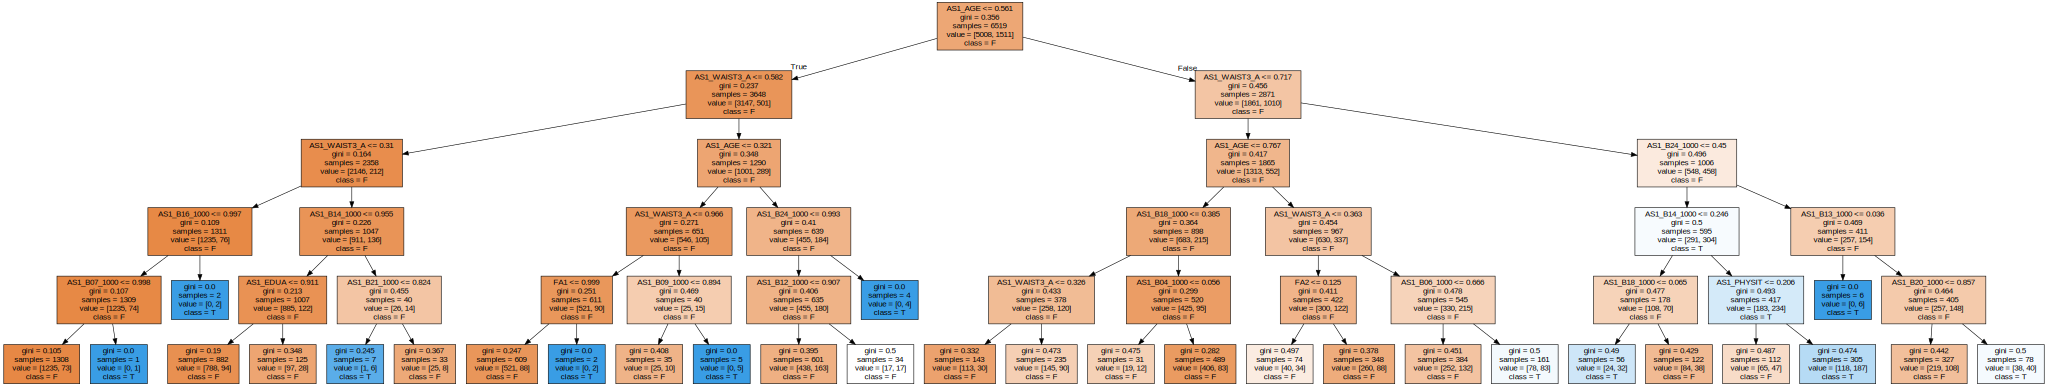

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

In [ ]:
# Define hyperparameters
tuned_parameters_xgb = {"max_depth": [3],
                        "colsample_bytree": [0.3, 0.7],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [100, 500, 1000]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters_xgb,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[18:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Best R²: 0.19239226561742367
